In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import simps

In [2]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


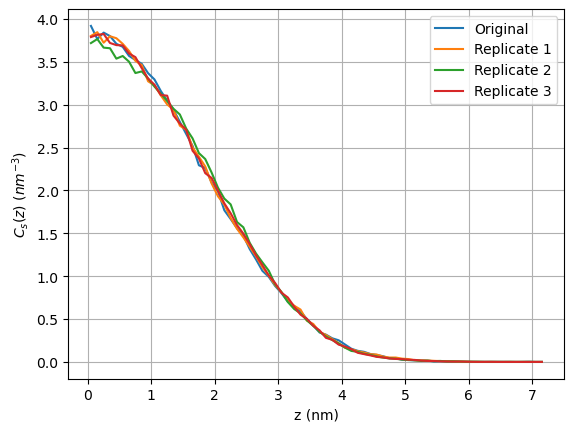

In [3]:
z_0, c_0 = compute_c_profile("density_hwl.xvg")
z_1, c_1 = compute_c_profile("density_hwr1.xvg")  # replicate 1
z_2, c_2 = compute_c_profile("density_hwr2.xvg")  # replicate 2
z_3, c_3 = compute_c_profile("density_hwr3.xvg")  # replicate 3

# Plot the concentration profiles
plt.figure()
plt.plot(z_0, c_0, label="Original")
plt.plot(z_1, c_1, label="Replicate 1")
plt.plot(z_2, c_2, label="Replicate 2")
plt.plot(z_3, c_3, label="Replicate 3")
plt.xlabel("z (nm)")
plt.ylabel(r"$C_s(z)$ ($nm^{-3}$)")
plt.grid()
plt.legend()


In [4]:
# Estimate the total number of ions, N_s (using Equation 13)
L_x, L_y, L_z = 4.8, 4.8, 14.4
N_s = L_x * L_y * simps(c_0, z_0)
print(N_s)  # this should be around 188

187.97002947984


In [5]:
def calc_lhs(theta, x):
    """
    Calculates the left hand side of Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    """
    NA = 6.02214076E23  # Avogadro's number
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Here we convert the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)  # Depends on if A is unitless or not ...

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)

    term_1 = -np.log(x / C_max)
    term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    term_4 = alpha_1 * (x - C_max) + alpha_2 * (x ** 2 - C_max ** 2)

    y_hat = term_1 + term_2 + term_3 + term_4

    return y_hat

In [6]:
def residuals(theta, x, y):
    return np.power(calc_lhs(theta, x) - y, 2)

In [7]:
def calc_potential_term(z, k=1.0457, T=300):
    """
    Calculates the scaled potential, i.e., the RHS of Equation 12.

    Parameters
    ----------
    z : numpy.ndarray
        The z-coordinates.
    k : float, optional
        The spring constant in kJ/mol/nm^2. Default is 1.0457.
    T : float, optional
        The temperature in Kelvin. Default is 300.

    Returns
    -------
    potential_term : numpy.ndarray
        The scaled potential term.
    """
    R = 8.31446261815324  # units: J/(mol*K)
    potential_term = -(0.5 * k * z ** 2) * 1000 / (R * T)

    return potential_term

In [8]:
def estimate_params(z_data, c_data, x0):
    """
    Fits Equation 12 to estimate the parameters B, alpha_1, and alpha_2.

    Parameters
    ----------
    z_data : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_data : numpy.ndarray
        The concentration profile.
    x0 : list
        The initial guess for the parameters B, alpha_1, and alpha_2.
    
    Returns
    -------
    theta : list
        The fitted parameters B, alpha_1, and alpha_2.
    """
    # Remove 0 values from the concentration profile, and the corresponding z values
    z_data = z_data[c_data != 0]
    c_data = c_data[c_data != 0]
    potential = calc_potential_term(z_data)  # scaled potential term, dimensionless
    result = least_squares(residuals, x0, args=(c_data, potential))
    
    # At this point, B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2), respectively
    B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]

    # Below we convert nm^(-3) to mol/L for the three parameters
    NA = 6.02214076E23  # Avogadro's number
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
    alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
    alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)

    print('- Fitted parameters:')
    print(f'  - B: {B:.3f} M^(-1/2)')
    print(f'  - alpha_1: {alpha_1:.3f} M^(-1)')
    print(f'  - alpha_2: {alpha_2:.3f} M^(-2)')
    print('- Cost function value:', result.cost)
    print('- Optimality:', result.optimality)
    print()

    theta = [B, alpha_1, alpha_2]

    return theta


In [9]:
theta_0 = estimate_params(z_0, c_0, [0.1, 0.1, 0.1])
theta_1 = estimate_params(z_1, c_1, [0.1, 0.1, 0.1])
theta_2 = estimate_params(z_2, c_2, [0.1, 0.1, 0.1])
theta_3 = estimate_params(z_3, c_3, [0.1, 0.1, 0.1])

- Fitted parameters:
  - B: 25317.002 M^(-1/2)
  - alpha_1: 6.733 M^(-1)
  - alpha_2: -0.721 M^(-2)
- Cost function value: 6165.330104353095
- Optimality: 0.00030763737959205173

- Fitted parameters:
  - B: 62748.355 M^(-1/2)
  - alpha_1: 5.917 M^(-1)
  - alpha_2: -0.631 M^(-2)
- Cost function value: 2615.5938594055465
- Optimality: 3.1945100545272e-05

- Fitted parameters:
  - B: 24216.087 M^(-1/2)
  - alpha_1: 6.454 M^(-1)
  - alpha_2: -0.708 M^(-2)
- Cost function value: 4267.575250117695
- Optimality: 0.00011371966502338182

- Fitted parameters:
  - B: 28622.969 M^(-1/2)
  - alpha_1: 5.848 M^(-1)
  - alpha_2: -0.625 M^(-2)
- Cost function value: 2358.3046901726834
- Optimality: 9.634130287849985e-05



In [10]:
# nm-based answers
NA = 6.02214076E23  # Avogadro's number
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
print(1.9247 / (conversion_factor ** (-0.5)))
print(9.3393E-2 / (conversion_factor ** (-1)))
print(3.4572E-2 / (conversion_factor)**(-2))

2.4802050938626055
0.15508272510056706
0.09532848685910528


In [11]:
def compute_osmotic_pressure(c_data, theta, nu=2, T=300):
    """
    Computes the osmotic pressure using Equation 16.

    Parameters
    ----------
    c_data : numpy.ndarray
        The concentration profile.
    theta : list
        A list containing the three parameters B, alpha_1, alpha_2.
    nu : int, optional
        The van't Hoff factor. Default is 2.
    T : int, optional
        The temperature in Kelvin. Default is 300.

    TODOS
    -----
    Check the units! There might be some mistakes here ...
    """
    A = 1.7964  # in M^(-1/2), value according to the SI
    R = 8.31446261815324  # units: J/(mol*K)
    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]
    term_1 = c_data
    term_2 = alpha_1 * (1/2) * c_data ** 2 + alpha_2 * (2/3) * c_data ** 3
    term_3 = A / B ** 2 * (2 / B) * np.log(1 + B * np.sqrt(c_data))
    term_4 = -A / B ** 2 * (2 * np.sqrt(c_data) + B * c_data) / (1 + B * np.sqrt(c_data))
    pi = nu * R * T * (term_1 + term_2 + term_3 + term_4)

    return pi
    

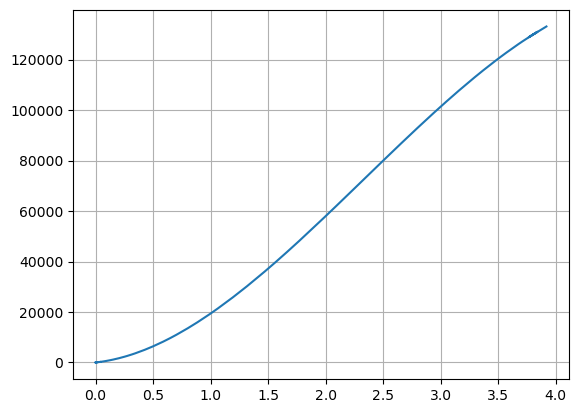

In [12]:
pi_0 = compute_osmotic_pressure(c_0, theta_0)

plt.figure()
plt.plot(c_0, pi_0)
plt.grid()